In [167]:
import os
import numpy as np
import torch
import torch.optim as optim
import models
from argparse import Namespace
import torch.optim as optim
import utils
import my_utils
import pandas as pd
import time
import vae_models
from glob import glob
import matplotlib.pyplot as plt
import sys
from dataset import DataSet
%matplotlib inline
from random import SystemRandom

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<ErrorbarContainer object of 3 artists>

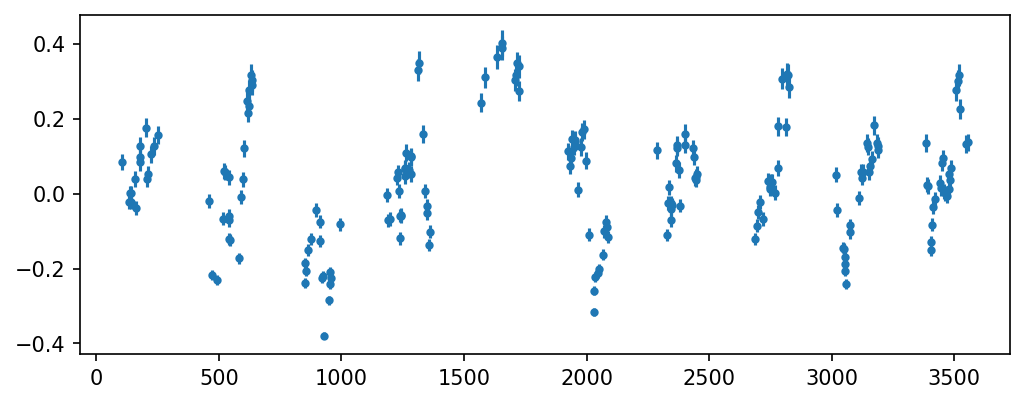

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from eztao.carma import DRW_term, DHO_term
from eztao.ts import gpSimRand

# define a DRW kernel & and simulate a process
amp, tau = np.log([0.2, 100])
DRW_kernel = DRW_term(amp, tau)
# def gpSimRand(carmaTerm, SNR, duration, N, nLC=1, log_flux=True, season=True, full_N=10_000):
t, y, yerr = gpSimRand(DRW_kernel, 10, 365*10, 200)
fig, ax = plt.subplots(1,1, dpi=150, figsize=(8,3))
ax.errorbar(t, y, yerr, fmt='.')

<ErrorbarContainer object of 3 artists>

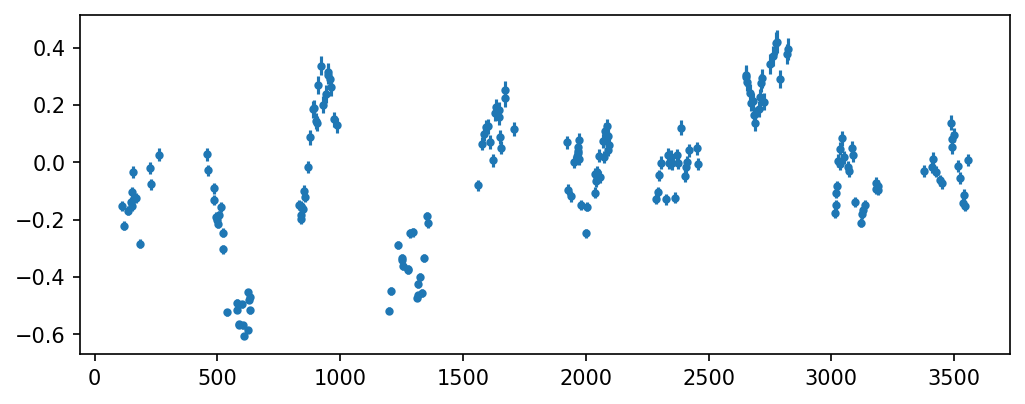

In [144]:
a1,a2,b1,b2 = np.log([1.0,1.0,1.0,1.0])
DHO_kernel = DHO_term(a1,a2,b1,b2)
t, y, yerr = gpSimRand(DRW_kernel, 10, 365*10, 200)
fig, ax = plt.subplots(1,1, dpi=150, figsize=(8,3))
ax.errorbar(t, y, yerr, fmt='.')

In [145]:
# TODO

# CREATE SYNTHETIC multivariate data, make hetvae compatible again
# last dim is time 
# middle dims are 



In [146]:
synth = np.array([gpSimRand(DRW_kernel, 10, 365*10, 200) for _ in range(100)]).transpose(0,2,1)

In [147]:
from eztao.carma import DRW_term, DHO_term
from eztao.ts import gpSimRand
import numpy as np
import torch
# probably want different vals for a1,a2,b0,b1
# params are E,omega,sigma,tau, 

### a1 = 2*E*omega
### a2 = omega**2
### b0 = sigma
### b1 = tau*sigma

# needs numpy, gpSimRand, DRW_Kernel

def get_synthetic_data(num_samples=100, dims= 1, batch_size=8, sim_params={'SNR':10, 'duration':10*365, 'N':200}, drw_kernel_params={'tau':100, 'amp':0.2}, dho_kernel_params = {'a1':1.0, 'a2':1.0, 'b0':1.0,'b1':1.0}, kernel='DRW'):
##### making synthetic data multivariate
    
    if kernel=='DRW':
        log_amp, log_tau = np.log([drw_kernel_params['amp'], drw_kernel_params['tau']])
        kernel = DRW_term(log_amp, log_tau)

    elif kernel=='DHO':
        log_a1,log_a2,log_b0,log_b1 = np.log([dho_kernel_params['a1'], dho_kernel_params['a2'], dho_kernel_params['b0'], dho_kernel_params['b1']])
        kernel=DHO_term(log_a1,log_a2,log_b0,log_b1)
        
    SNR, duration, N = sim_params['SNR'], sim_params['duration'], sim_params['N']
    synth = np.array([gpSimRand(kernel, SNR, duration, N) for _ in range(num_samples)]).transpose(0,2,1)
                                                                                                 
                                                                     
    size = int(num_samples / dims)
    num_examples = synth.shape[0]
    union_tps_all = []
    data = np.zeros((num_examples, num_samples, dims))
    samples = []
    max_union_tps = []
    for i in range(num_examples):
        union_tps = []
        sample = []
        subset_lengths = np.random.randint(low=50, high=100, size=dims)
        # each dimension could be a random subset of the original, scaled, shifted,
        for j in range(dims):   
            obs_points = np.sort(np.random.choice(np.arange(num_samples), size=subset_lengths[j], replace=False))
            sample_j = synth[i, obs_points, :]

            ##### here we could vary y vals, t vals for each dim
            #sample_j[:,0] += np.random.uniform(50,100)# shift by arbitrary amount!
            #sample_j[:,1] *= np.random.rand() # scale by arbitrary amount!

            union_tps.extend(sample_j[:, 0])
            t,y,yerr = sample_j[:,0], sample_j[:,1], sample_j[:,2]
            sample.append(sample_j)

        samples.append(sample)
        union_tps = list(set(union_tps))
        union_tps.sort() # save these 
        union_tps_all.append(union_tps)
        if len(union_tps) > len(max_union_tps):
            max_union_tps = union_tps


    for i in range(num_examples):
        sample = samples[i]
        for j in range(dims):
            sample_j = sample[j]
            new_t = union_tps_all[i]
            new_y = np.zeros(len(new_t))
            new_yerr = np.zeros(len(new_t))
            # get relative indexes
            mask = np.isin(new_t, sample_j[:,0])
            indexes = np.where(mask)[0]
            # subsampled the mask! # maybe astromer one? -------------- 
            subsampled_mask = np.zeros_like(new_y)
            recon_mask = np.zeros_like(new_y)

            length = int((mask * 1).sum() * np.random.uniform(0.35, 0.65))
            obs_points = np.sort(np.random.choice(indexes, size=length, replace=False))
            subsampled_mask[obs_points] = 1
            recon_mask = np.logical_xor(subsampled_mask, recon_mask)
            #-----------------------------------------------------------

            new_y[indexes] = sample_j[:,1]
            new_yerr[indexes] = sample_j[:,2]

            need_to_append = len(max_union_tps) - len(new_t)
            sample_j = np.array([new_t, new_y, new_yerr, mask, subsampled_mask, recon_mask]).T
            sample_j = np.append(sample_j, np.zeros((need_to_append, 6)), axis=0)
            # mask subsampled masks?


            samples[i][j] = sample_j


    samples = np.array(samples)
    # torch loader
    samples = samples.astype('float32')
    np.random.shuffle(samples)
    print(samples.shape)
    splindex = int(np.floor(.8*len(samples)))
    training, valid, test = np.split(samples, [splindex, splindex + int(np.floor(.1*len(samples)))])# shuffle?
    print(training.shape, valid.shape, test.shape)
    # normalizing?
    
    train_loader = torch.utils.data.DataLoader(training, batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)
    max_union_tps = torch.Tensor(max_union_tps)
    
    
    
    data_objects = {
        "train_loader": train_loader,
        "test_loader": test_loader,
        "valid_loader": valid_loader,
        'union_tp': max_union_tps,
        "input_dim": dims,
    }
    
    return samples, max_union_tps, data_objects


In [148]:
samples, max_union_tps, dos = get_synthetic_data(num_samples = 100, kernel='DHO')

(100, 1, 99, 6)
(80, 1, 99, 6) (10, 1, 99, 6) (10, 1, 99, 6)


In [149]:
x = dos['valid_loader']
len(x)

2

<ErrorbarContainer object of 3 artists>

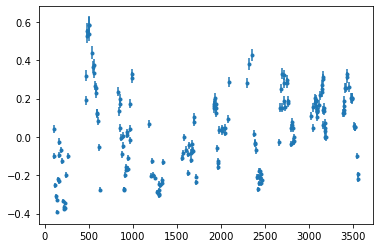

In [150]:

synth1 = synth[0]
plt.errorbar(synth1[:,0], synth1[:,1], synth1[:,2], fmt='.')

In [151]:
args = Namespace(batch_size=8, bound_variance=False, const_var=False,dropout=0.19462264721791603, 
                 elbo_weight=4.108914123847402, embed_time=32, enc_num_heads=4, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=32, lr=0.001, mixing='concat_and_mix', mse_weight=4.060280688730988, net='hetvae', 
                 niters=1000, norm=True, normalize_input='znorm', num_ref_points=32, rec_hidden=32, recon_loss=False, 
                 sample_tp=0.4733820088130086, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=512, device='mps')



In [152]:
DIM = 1
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('mps' if torch.has_mps else 'cpu')

In [157]:
samples = samples.astype('float32')
training, valid = np.split(samples, [int(np.floor(1*len(samples)))])# shuffle?
train_loader = torch.utils.data.DataLoader(training, batch_size=args.batch_size)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=args.batch_size)
max_union_tps = torch.Tensor(max_union_tps)

In [158]:
net = models.load_network(args, DIM, max_union_tps)
#net = models.load_network(args, DIM, torch.Tensor(Edelson.union_x))  
params = list(net.parameters())
optimizer = optim.Adam(params, lr=0.003572758547163779)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=150)

In [159]:
for g in optimizer.param_groups:
    print(g['lr'])
    g['lr'] = 0.001463275753032352

0.003572758547163779


In [160]:
max_union_tps.shape
torch.has_mps

True

In [168]:
for itr in range(1, 10 + 1):
    train_loss = 0
    train_n = 0
    avg_loglik, avg_kl, mse, mae = 0, 0, 0, 0
    experiment_id = int(SystemRandom().random() * 10000000)
    for train_batch in train_loader:
        batch_len = train_batch.shape[0]
        train_batch = train_batch.to(device)

        subsampled_mask = train_batch[:,:,:,4]
        recon_mask = train_batch[:,:,:,5]

        context_y = torch.cat((
          train_batch[:,:,:,1] * subsampled_mask, subsampled_mask
        ), 1).transpose(2,1) # torch.Size([128, 203, 82]) # batch size, length, dims
        # torch.Size([128, 203])
        recon_context_y = torch.cat((
          train_batch[:,:,:,1] * recon_mask, recon_mask
        ), 1).transpose(2,1)

        #print(recon_context_y.shape, context_y.shape,train_batch[:, 0, :,0].shape )
        loss_info = net.compute_unsupervised_loss(
            train_batch[:, 0, :,0],
            context_y,
            train_batch[:, 0, :,0],
            recon_context_y,
            num_samples=args.k_iwae,
            beta=1,
            )
        optimizer.zero_grad()
        loss_info.composite_loss.backward()
        optimizer.step()
        train_loss += loss_info.composite_loss.item() * batch_len
        avg_loglik += loss_info.loglik * batch_len
        avg_kl += loss_info.kl * batch_len
        mse += loss_info.mse * batch_len
        mae += loss_info.mae * batch_len
        train_n += batch_len
    print(itr)
    if itr % 10 == 0:
        print(
            'Iter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg kl: {:.4f}, '
            'mse: {:.6f}, mae: {:.6f}'.format(
              itr,
              train_loss / train_n,
              -avg_loglik / train_n,
              avg_kl / train_n,
              mse / train_n,
              mae / train_n
            )
        )

    if itr % 10 == 0:
        torch.save({
            'args': args,
            'epoch': itr,
            'state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss / train_n,
        }, 'synth' + '_' + str(experiment_id) + '.h5')


#           for loader, num_samples in [(valid_loader, 5), (test_loader, 100)]:
#               utils.evaluate_hetvae(
#                   net,
#                   dim,
#                   loader,
#                   0.5,
#                   shuffle=False,
#                   k_iwae=num_samples,
#                   device=device
#               )
# torch.Size([8, 122, 6]) torch.Size([8, 122, 6]) torch.Size([8, 122]) dim = 3
# torch.Size([8, 99, 2]) torch.Size([8, 99, 2]) torch.Size([8, 99]) dim = 1

1
2
3
4
5
6
7
8
9
10
Iter: 10, train loss: 9.8999, avg nll: 1.4200, avg kl: 0.0003, mse: 1.000892, mae: 0.795161


(2, 123, 99, 1) (2, 123, 99, 1) (123, 1, 99) (123, 1, 99) (123, 99)
(123, 99, 1) (123, 99, 1) (123, 99, 1) (2, 123, 99, 1) (123, 1, 99)
(99, 1)


ValueError: x and y must be the same size

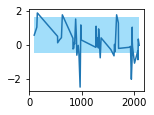

In [141]:
viz(train_loader)

In [140]:
def viz(dataloader, device='mps', k_iwae=2, n_max=5):
    pred_mean, pred_std = [], []
    masks = []
    targets = []
    tp =[]
    np.random.seed(0)
    with torch.no_grad():
        for batch in dataloader:
            batch_len = batch.shape[0]
            batch = batch.to(device)
            subsampled_mask = batch[:,:,:,4]
            recon_mask = batch[:,:,:,5]
            seqlen = batch.size(1)
            context_y = torch.cat((batch[:,:,:,1] * subsampled_mask, subsampled_mask), 1).transpose(2,1)
            # context_x = train_batch[:,0,:,0], where we'd set a target x
            #print(batch[:, 0, :,0].shape)
            px, _ = net.get_reconstruction(batch[:, 0, :,0], context_y, batch[:, 0, :,0], num_samples=k_iwae)
            pred_mean.append(px.mean.cpu().numpy())
            pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())
            targets.append((batch[:, :, :,1]).cpu().numpy())
            masks.append(subsampled_mask.cpu().numpy())
            tp.append(batch[:, 0, :,0].cpu().numpy())
       
    pred_mean = np.concatenate(pred_mean, axis=1)
    pred_std = np.concatenate(pred_std, axis=1)
    targets = np.concatenate(targets, axis=0)
    masks = np.concatenate(masks, axis=0)
    tp = np.concatenate(tp, axis=0)
    print(pred_mean.shape, pred_std.shape, targets.shape, masks.shape, tp.shape)
    inputs = np.ma.masked_where(masks < 1., targets)
    # reparam trick, add  random number to everything
    preds = np.random.randn(k_iwae//2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean
    preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])
    median = preds.mean(0)
    pred_std = pred_std.mean(0)
#     median = preds.mean(0) #np.quantile(preds, 0.5, axis=0)
    quantile2 = np.quantile(preds, 0.841, axis=0)
    quantile1 = np.quantile(preds, 0.159, axis=0)
    print(quantile2.shape,median.shape,pred_std.shape,preds.shape)
    w = 2.0
    print((median[0] - pred_std[0]).shape)
    for index in range(n_max):
        plt.figure(figsize=(12, 1.5))
        plt.subplot(1,n_max,index + 1)
        upto = np.argwhere(tp[index] == 0)[0,0]
        
        plt.fill_between(tp[index, :upto], median[index,0,:upto] - pred_std[index,0,:upto], median[index,0,:upto] + pred_std[index,0,:upto], alpha=0.6, facecolor='#65c9f7', interpolate=True)
        plt.plot(tp[index, :upto], median[index, :upto])
        plt.scatter(tp[index, :upto], inputs[index, :upto])
        
        
#         for j in range(3):
#             plt.subplot(1, 3, j + 1)
#             plt.fill_between(tp[n_max * j + index], quantile1[n_max * j + index, :, 0], quantile2[n_max * j + index, :, 0], alpha=0.6, facecolor='#65c9f7', interpolate=True)
#             plt.plot(tp[n_max * j + index], median[n_max * j + index, :, 0], c='b', lw=w, label='Reconstructions')
#             plt.scatter(tp[n_max * j + index], inputs[n_max * j + index, :, 0], c='k', lw=w, label='Observed Data')
#             plt.xlim([0, 1])
#             plt.xticks([])
#             plt.yticks([])
#             if j == 1 and index == 0:
#                 plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.6,1.5))
            
        plt.show()

NameError: name 'tp' is not defined

In [ ]:
net = models.load_network(args, DIM, max_union_tps)
#net = models.load_network(args, DIM, torch.Tensor(Edelson.union_x))  
params = list(net.parameters())
optimizer = optim.Adam(params, lr=0.003572758547163779)


# need same union_tp & dataset obv
def load_checkpoint(filename, data_obj):
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        cp = torch.load(filename)
        data_obj = my_utils.get_synthetic_data(seed=cp['args'].seed)
        net = models.load_network(cp['args'])
        #dict_keys(['args', 'epoch', 'state_dict', 'optimizer_state_dict', 'loss'])
        # can just load the same synthetic data, so long as the seed is the same!
        # workflow will probably be on the same system so idk? depends
        # want to be able to call this function adn then keep training the network?
        
        
        